In [1]:
#seaborn is required for the traceplots
import pysal as ps
import hlm
from hlm.verify import Delta_members
from hlm.plotting.traces import plot_trace
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = ps.pdio.read_files(ps.examples.get_path('south.shp'))
df = df[df.STATE_NAME != 'District of Columbia']
X = df[['GI89', 'BLK90', 'HR90']].values
N = X.shape[0]
Z = df.groupby('STATE_NAME')['FH90'].mean()
Z = Z.values.reshape(-1,1)
J = Z.shape[0]

Y = df.DNL90.values.reshape(-1,1)
W2 = ps.queen_from_shapefile(ps.examples.get_path('us48.shp'), 
                             idVariable='STATE_NAME')
W2 = ps.w_subset(W2, ids=df.STATE_NAME.unique().tolist())
W1 = ps.queen_from_shapefile(ps.examples.get_path('south.shp'),
                             idVariable='FIPS')
W1 = ps.w_subset(W1, ids=df.FIPS.tolist())

W1.transform = 'r'
W2.transform = 'r'
membership = df.STATE_NAME.apply(lambda x: W2.id_order.index(x)).values
Delta, membership = Delta_members(None, membership, W1.n, W2.n)

/home/levi/dev/hlm_gibbs/hlm/abstracts.py:5: UserWarning: The `dill` module is required to use the sqlite backend. No module named 'dill'
  from .sqlite import head_to_sql, start_sql


In [2]:
WZ = ps.lag_spatial(W2, Z)
ZDurbin = np.hstack((Z, WZ))

In [3]:
m2 = hlm.upper.SMA(Y, X, M=W2, Z=ZDurbin, membership=membership,
                   n_samples=5000)

/home/levi/dev/hlm_gibbs/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/levi/dev/hlm_gibbs/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


/home/levi/miniconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


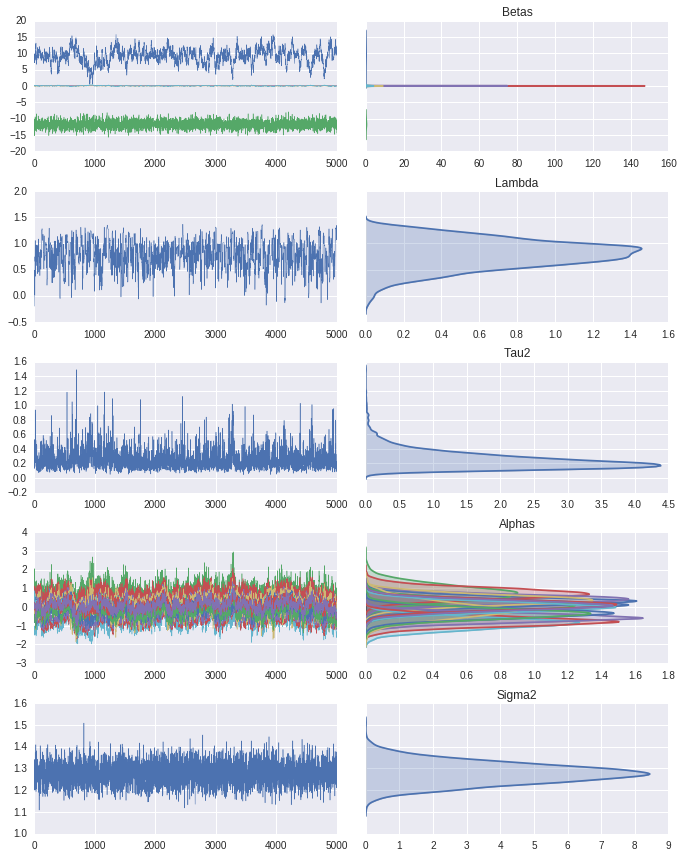

In [4]:
plot_trace(m2)
plt.tight_layout()
plt.show()

In [5]:
m3 = hlm.upper.SE(Y, X, M=W2, Z=ZDurbin, 
                  membership=membership, n_samples=5000)

/home/levi/dev/hlm_gibbs/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/levi/dev/hlm_gibbs/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


/home/levi/miniconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


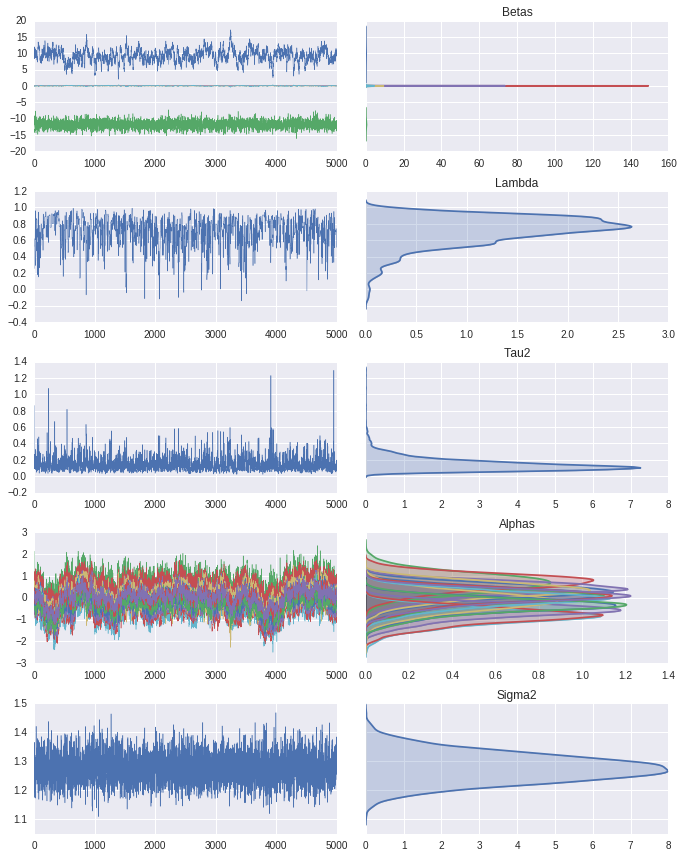

In [6]:
m3.trace.plot()
plt.tight_layout()

In [7]:
true_betas = np.array([[3,5,6]]).T
true_gamma = np.array([[-3, 10]]).T
true_lambda = -.45
true_sigma = 5
true_tau =  2

In [8]:
linpred = 1 + X.dot(true_betas) + Delta.dot(ZDurbin).dot(true_gamma)
B = (np.eye(W2.n) - true_lambda * W2.full()[0])
error = Delta.dot(np.linalg.inv(B)).dot(np.random.normal(0,true_tau,size=Z.shape))
error += np.random.normal(0,true_sigma, size=(X.shape[0], 1))
Yk = linpred + error

In [9]:
m3 = hlm.upper.SE(Yk, X, M=W2, Z=ZDurbin, 
                  membership=membership, n_samples=11000, tuning=1000)

/home/levi/dev/hlm_gibbs/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/levi/dev/hlm_gibbs/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


/home/levi/miniconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


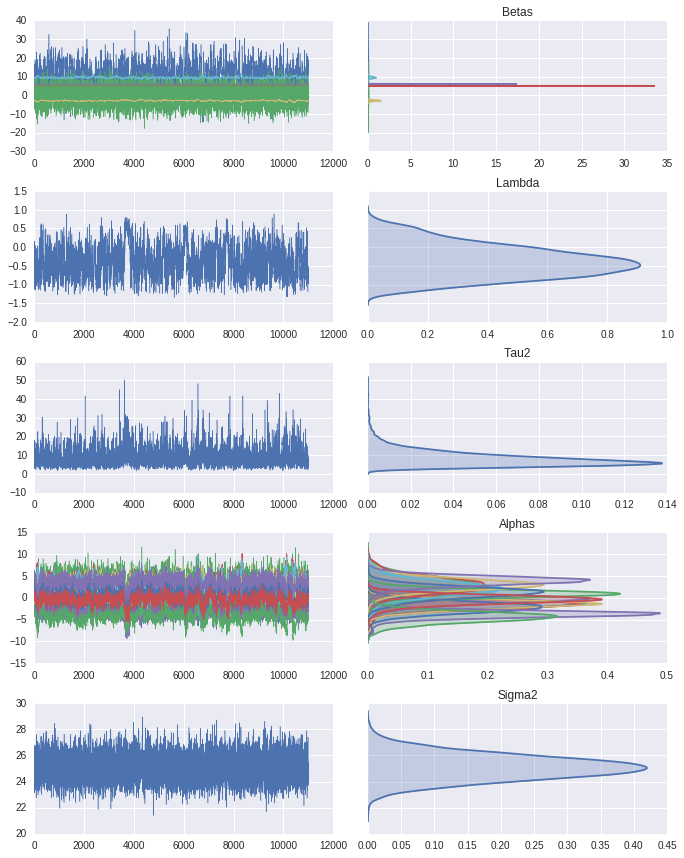

In [10]:
plot_trace(m3)
plt.tight_layout()

In [12]:
np.mean(m3.trace.Lambda)

-0.39151721935522732

In [13]:
true_betas = np.array([[3,5,6]]).T
true_gamma = np.array([[-3, 10]]).T
true_lambda = .6
true_sigma = .5
true_tau =  .2

In [14]:
linpred = 1 + X.dot(true_betas) + Delta.dot(ZDurbin).dot(true_gamma)
B = (np.eye(W2.n) + true_lambda * W2.full()[0])
error = Delta.dot(B).dot(np.random.normal(0,true_tau,size=Z.shape))
error += np.random.normal(0,true_sigma, size=(X.shape[0], 1))
Yk = linpred + error

In [15]:
m3 = hlm.upper.SMA(Yk, X, M=W2, Z=ZDurbin, 
                  membership=membership, n_samples=11000, tuning=1000)

/home/levi/dev/hlm_gibbs/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/levi/dev/hlm_gibbs/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


In [16]:
np.median(m3.trace.Lambda[1000:]), np.std(m3.trace.Lambda[1000:])

(0.78709136111694611, 0.36151809429655368)

/home/levi/miniconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


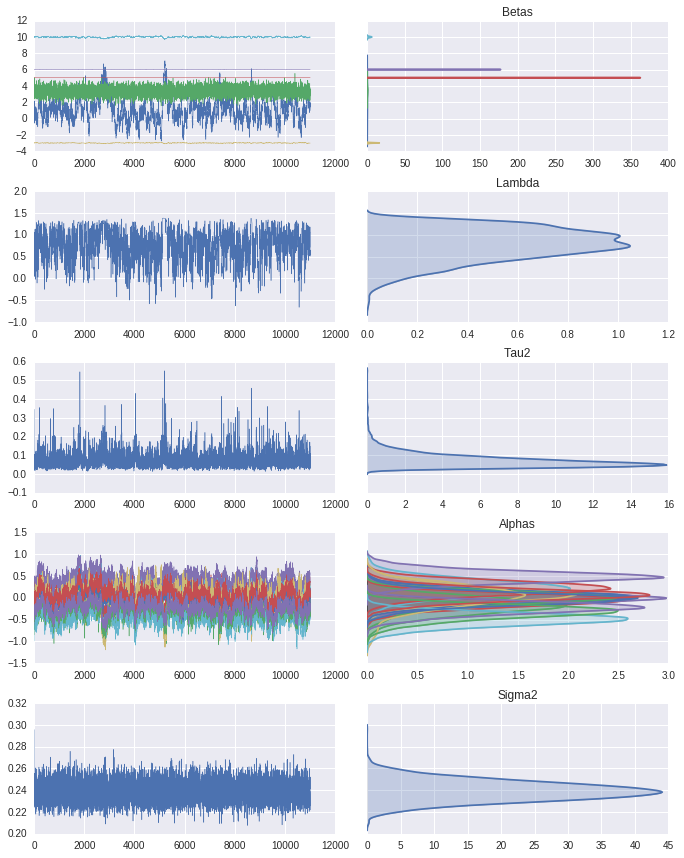

In [17]:
m3.trace.plot()
plt.tight_layout()
plt.show()

In [13]:
mvcm = hlm.both.MVCM(Y, X, Z=ZDurbin, 
                     membership=membership, n_samples=5000)

/home/levi/miniconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


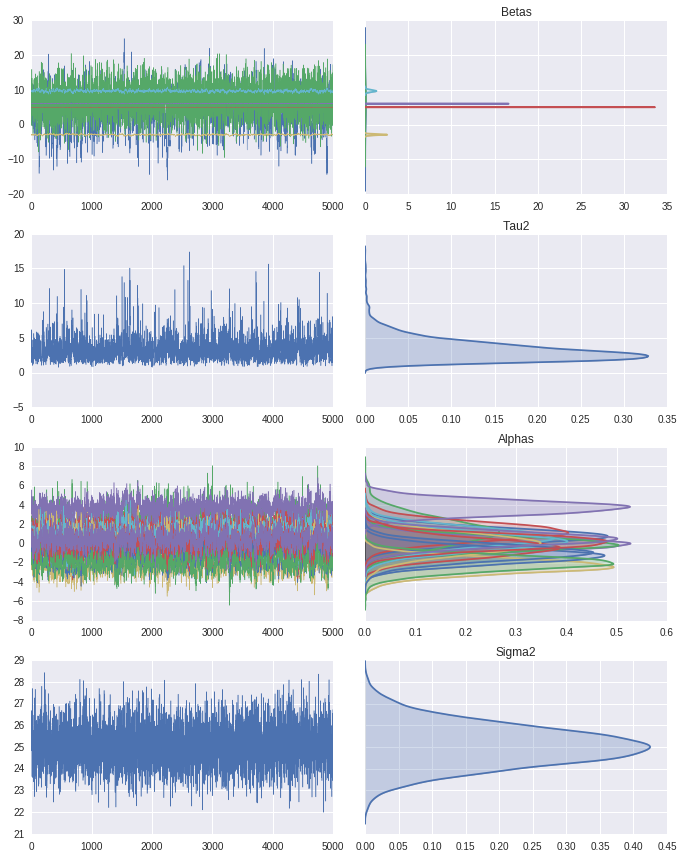

In [14]:
mvcm.trace.plot()
plt.tight_layout()

In [20]:
m4 = hlm.both.Generic(Y, X, Z=ZDurbin, W=W1, M=W2,
                      membership=membership, n_samples=5000)

/home/ljw/Downloads/hlm_review/what_i_have_done/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/ljw/Downloads/hlm_review/what_i_have_done/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)
/home/ljw/Downloads/hlm_review/what_i_have_done/hlm/abstracts.py:38: UserWarning: Sampling interrupted, drew 1570 samples
  Warn('Sampling interrupted, drew {} samples'.format(self.cycles))


/home/ljw/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


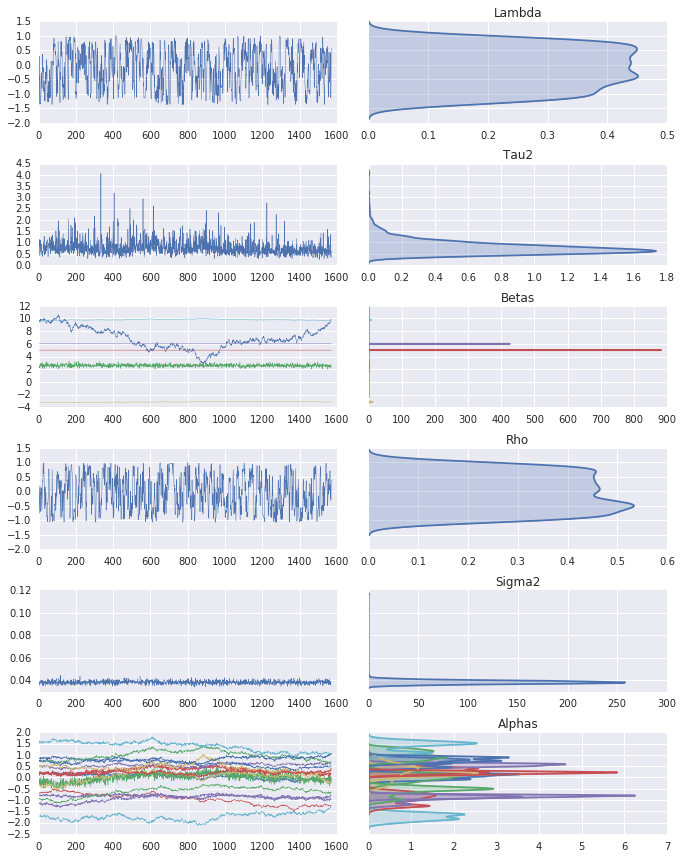

In [21]:
m4.trace.plot()
plt.tight_layout()

In [24]:
import pandas as pd

In [25]:
pd.DataFrame([m4.trace.to_df().mean(), mvcm.trace.to_df().mean()]).T

,0,1
Alphas_0,0.042976,0.370788
Alphas_1,0.001364,0.018086
Alphas_10,0.239981,-0.232404
Alphas_11,1.388786,1.518264
Alphas_12,0.788608,1.244799
Alphas_13,-0.609997,-0.589036
Alphas_14,0.202616,0.593573
Alphas_15,-0.931109,-0.819365
Alphas_2,0.311492,0.388391
Alphas_3,0.539329,0.922664


In [33]:
true_betas = np.array([[10], [4], [2]])
true_gammas = np.array([[.5], [-4]])
true_lambda = .25
true_tau = 5
true_sigma = 1

In [37]:
Bi = np.linalg.inv(np.eye(W1.n) - true_lambda * W1.full()[0])
Yvclse = (-5 +  X.dot(true_betas) + Delta.dot(ZDurbin).dot(true_gammas)
          + Bi.dot(np.random.normal(0,true_sigma,size=(X.shape[0],1)))
          + Delta.dot(np.random.normal(0, true_tau, size=(ZDurbin.shape[0],1))))

In [38]:
test_mod = hlm.lower.SE(Yvclse, X=X, Z=ZDurbin, W=W1, membership=membership, tuning=1000, n_samples=5000)

/home/levi/dev/hlm_gibbs/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/levi/dev/hlm_gibbs/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)
/home/levi/dev/hlm_gibbs/hlm/abstracts.py:36: UserWarning: Sampling interrupted, drew 1788 samples
  Warn('Sampling interrupted, drew {} samples'.format(self.cycles))


/home/levi/miniconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


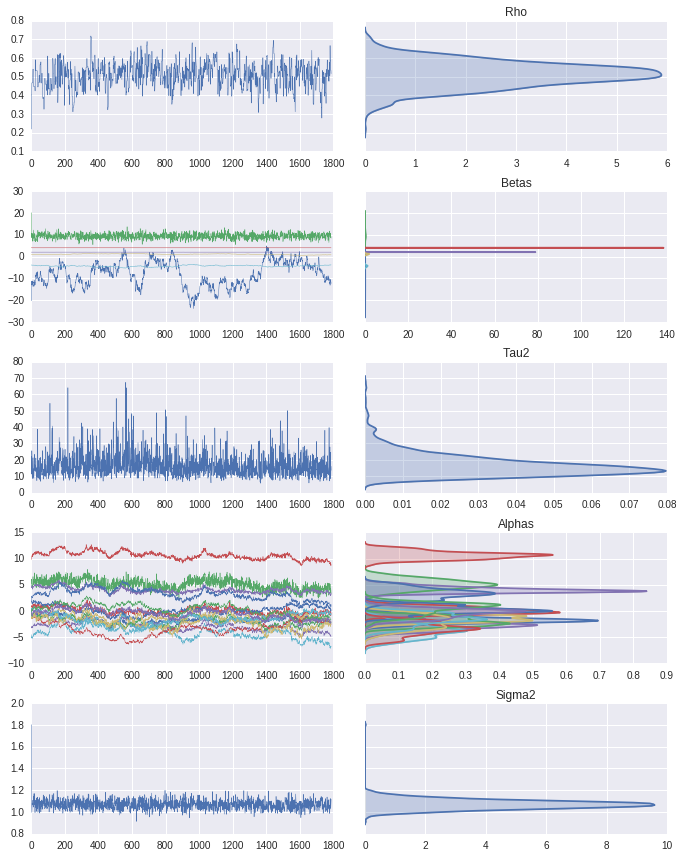

In [39]:
test_mod.trace.plot()
plt.tight_layout()
plt.show()

In [46]:
np.asarray(test_mod.trace.Betas[1000:]).mean(axis=0)

array([[-7.89654392],
       [ 9.37429411],
       [ 4.00196558],
       [ 1.99984231],
       [ 0.91447884],
       [-4.2794268 ]])

In [47]:
np.asarray(test_mod.trace.Rho[1000:]).mean(axis=0)

0.50918096282413783

In [48]:
np.asarray(test_mod.trace.Tau2[1000:]).mean(axis=0)

15.55089062875104

In [49]:
np.asarray(test_mod.trace.Sigma2[1000:]).mean(axis=0)

1.065236873074132

In [69]:
test_mod.state.LogRho0(.2)

array([-0.72749709])

In [77]:
instate = test_mod.state.Psi_1(.25, W1.sparse)
manual = np.linalg.inv(np.eye(N) - .25 * W1.sparse)

In [78]:
np.testing.assert_allclose(instate, manual)

In [80]:
np.allclose((np.eye(N) - .25 * W1.sparse).dot(np.eye(N) - .25 * W1.sparse), np.eye(N) - .25 * W1.sparse)

False

In [50]:
tm2 = hlm.both.MVCM(Yvclse, X=X, Z=ZDurbin, W=W1, membership=membership, tuning=1000, n_samples=20000)

/home/levi/miniconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


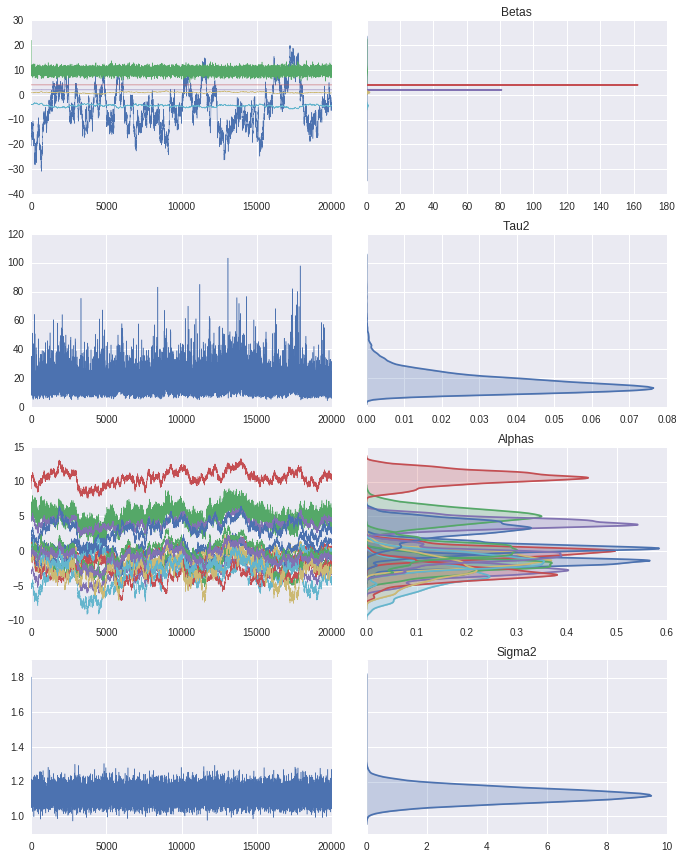

In [53]:
tm2.trace.plot()
plt.tight_layout()
plt.show()

In [54]:
np.asarray(tm2.trace.Betas[1000:]).mean(axis=0)

array([[-4.96994082],
       [ 9.56169801],
       [ 4.00155213],
       [ 2.00093549],
       [ 0.94298882],
       [-4.50781593]])

In [55]:
np.asarray(tm2.trace.Sigma2[1000:]).mean()

1.1236951724919237

In [56]:
np.asarray(tm2.trace.Tau2[1000:]).mean()

17.067336489675355

/home/levi/miniconda3/envs/py3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


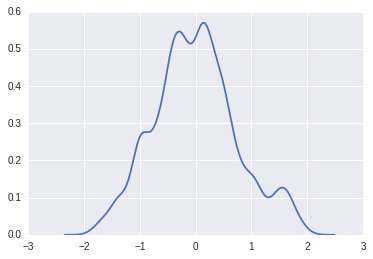

In [64]:
hypermean = np.asarray(tm2.trace.Alphas[1000:]).mean()
zetas = np.asarray(tm2.trace.Alphas[1000:]) - hypermean
mean_zetas = zetas.mean(axis=1)
sns.kdeplot(mean_zetas.flatten())

In [65]:
hypermean

0.22538130322587371